In [1]:
import glob
import os
import pickle
import pandas as pd

# plot heatmap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib

In [2]:
import torch
from analyze import get_dfa_probs as calculate_dfa_probs
from ngram import (
    predict_with_n_gram_back_off,
    prob_distance,
    prob_distance_dfa,
    prob_distance_dfa_ngram,
)

from batched_baum_welch import predict_with_baumwelch

/raid/lingo/akyurek/anaconda3/envs/iclmodels/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Vocab:
    def __init__(self, vocab: list):
        self.vocab = vocab
        # inverse vocab
        self.inv_vocab = {v: k for k, v in enumerate(vocab)}

    def get_vocab(self, id):
        return self.vocab[id]

    def get_id(self, char):
        return self.inv_vocab[char]

    def __len__(self):
        return len(self.vocab)


def get_ngram_probs(results, ngram=3, uniform=False, backoff=False, addone=False):
    vocab = Vocab(results[0]["vocab"])
    n_gram_probs = []
    # make multiprocessing


    for b in range(len(results)):
        input = results[b]["input"]
        target = [vocab.get_id(t) for t in results[b]["target"]]
        probs = predict_with_n_gram_back_off(
            input,
            N=ngram,
            global_vocab=vocab,
            uniform=uniform,
            backoff=backoff,
            addone=addone,
        )
        n_gram_probs.append(probs)
    return n_gram_probs


def get_baumwelch_probs(results):
    vocab = Vocab(results[0]["vocab"])
    baumwelch_probs = []
    for b in range(len(results)):
        input = results[b]["input"]
        probs = predict_with_baumwelch(input, vocab, max_states=12)
        baumwelch_probs.append(probs)
    return baumwelch_probs

# from concurrent.futures import ThreadPoolExecutor

# def get_baumwelch_probs(results):
#     vocab = Vocab(results[0]["vocab"])

#     def process_result(result):
#         input = result["input"]
#         return predict_with_baumwelch(input, vocab, max_states=12)

#     with ThreadPoolExecutor() as executor:
#         baumwelch_probs = list(executor.map(process_result, results))

#     return baumwelch_probs


def get_dfa_probs(results):
    vocab = Vocab(results[0]["vocab"])
    dfa_probs = []
    for b in range(len(results)):
        input = results[b]["input"]
        target = [vocab.get_id(t) for t in results[b]["target"]]
        probs = calculate_dfa_probs(input, results[b]["dfa"], vocab=vocab)
        dfa_probs.append(probs)
    return dfa_probs


def get_model_probs(results, softmax=True):
    model_probs = []
    for b in range(len(results)):
        if softmax:
            probs = (
                torch.softmax(torch.tensor(results[b]["probs"]), dim=-1)
                .detach()
                .cpu()
                .numpy()
            )
        else:
            probs = results[b]["probs"]
        model_probs.append(probs)
    return model_probs


import numpy as np


def get_greedy_dfa_accuracy(probs, dfa_probs, offset=0, max_len=None):
    total = 0.0
    correct = 0.0
    for p1, pdfa in zip(probs, dfa_probs):
        if max_len is not None:
            pdfa = pdfa[offset:max_len]
        indices = p1.argmax(axis=-1)[: len(pdfa)]
        correct += (pdfa[np.arange(len(pdfa)), indices] > 0).sum()
        total += len(pdfa)
    return correct / total


EPS = 1e-7


def get_kl(probs, dfa_probs, offset=0, max_len=None):
    total = 0.0
    cross_entropy = 0.0
    for p1, pdfa in zip(probs, dfa_probs):
        # calculate the soft cross-entropy between p1 and pdfa
        if max_len is not None:
            pdfa = pdfa[offset:max_len]
        log_p1 = np.log(p1[: len(pdfa)] + EPS)
        log_pdfa = np.log(pdfa + EPS)
        cross_entropy += -((log_p1 - log_pdfa) * pdfa).sum()
        total += len(pdfa)
    return cross_entropy / total


def get_l1_loss(probs1, probs2, probsdfa, offset=0, max_len=None):
    total = 0.0
    correct = 0.0
    for p1, p2, pdfa in zip(probs1, probs2, probsdfa):
        if max_len is not None:
            pdfa = pdfa[offset:max_len]
        total += len(pdfa)
        correct += np.abs(
            p1[offset : offset + len(pdfa)] - p2[offset : offset + len(pdfa)]
        ).sum()
    return correct / total

In [4]:
# glob all checkpoints
run_folders = glob.glob(
    "experiments/hiddens_*/**/generations/*test_batch/", recursive=True
)
# create a map
name_to_folder = {}
for folder in run_folders:
    folder = folder.replace("//", "/").strip("/")
    subpaths = folder.split("/")
    name = subpaths[2]
    num_examples = subpaths[1].split("_")[1]
    nlayer = "" if subpaths[3] == "generations" else subpaths[3]
    name = f"{num_examples}/{name}/{nlayer}"
    name_to_folder[name] = folder

In [5]:
name_to_folder

{'2500/lstm/': 'experiments/hiddens_2500/lstm/generations/142_test_batch',
 '2500/mamba/': 'experiments/hiddens_2500/mamba/generations/158_test_batch',
 '2500/h3/': 'experiments/hiddens_2500/h3/generations/47_test_batch',
 '2500/transformer_2/': 'experiments/hiddens_2500/transformer_2/generations/197_test_batch',
 '2500/s4d/': 'experiments/hiddens_2500/s4d/generations/54_test_batch',
 '2500/transformer_4/': 'experiments/hiddens_2500/transformer_4/generations/155_test_batch',
 '2500/retention/': 'experiments/hiddens_2500/retention/generations/106_test_batch',
 '2500/transformer_1/': 'experiments/hiddens_2500/transformer_1/generations/13_test_batch',
 '2500/hyena/': 'experiments/hiddens_2500/hyena/generations/59_test_batch',
 '2500/rwkv/': 'experiments/hiddens_2500/rwkv/generations/20_test_batch',
 '2500/linear_transformer/': 'experiments/hiddens_2500/linear_transformer/generations/40_test_batch',
 '2500/transformer/': 'experiments/hiddens_2500/transformer/generations/176_test_batch',
 '

In [6]:
# import functools
# import concurrent
# import pickle
# def read_one(fname, probs_only=False):
#     with open(fname, "rb") as f:
#         data =  pickle.load(f)
#         if "hidden_outputs" in data:
#             del data["hidden_outputs"]
#         if "attention_scores" in data:
#             del data["attention_scores"]
#         if "attention_contexts" in data:
#             del data["attention_contexts"]

#     with open(fname, 'wb') as f:
#         pickle.dump(data, f)

#     return data


# def read_parallel(file_names, probs_only=False):
#     reader = functools.partial(read_one, probs_only=probs_only)
#     with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
#         futures = [executor.submit(reader, f) for f in file_names]
#         return [fut.result() for fut in futures]

# for model in name_to_folder.keys():
#     if model.startswith("20000"):
#         print(model)
#         folder = name_to_folder[model]
#         files = glob.glob(f"{folder}/*.pkl")
#         print(files[0])
#         read_parallel(files, probs_only=True)

In [7]:
from probe import get_results

In [8]:
results = {}
for num_examples in (1000, 2500, 5000, 10000, 20000, 40000):
    results[num_examples] = {}
    for model in (
        "transformer",
        "lstm",
        "hyena",
        "h3",
        "s4d",
        "linear_transformer",
        "rwkv",
        "retention",
        "transformer_4",
        "transformer_8",
        "transformer_2",
        "transformer_1",
        "mamba",
    ):
        name = f"{num_examples}/{model}/"
        if model in results[num_examples]:
            continue
        try:
            results[num_examples][model] = get_results(
                name_to_folder[name], probs_only=True
            )
        except:
            print(f"Failed to load {name}")
    for model in ("2gram", "3gram"):
        file = f"experiments/hiddens_{num_examples}/{model}/probs.pkl"
        try:
            results[num_examples][model] = pickle.load(open(file, "rb"))
        except Exception as e:
            print(e)
            print(f"Failed to load {file}")

Failed to load 1000/transformer_4/
Failed to load 1000/transformer_8/
Failed to load 1000/transformer_2/
Failed to load 1000/transformer_1/
Failed to load 2500/transformer_8/
Failed to load 5000/transformer_4/
Failed to load 5000/transformer_8/
Failed to load 5000/transformer_2/
Failed to load 5000/transformer_1/
Failed to load 10000/transformer_4/
Failed to load 10000/transformer_8/
Failed to load 10000/transformer_2/
Failed to load 10000/transformer_1/
Failed to load 20000/linear_transformer/
Failed to load 20000/transformer_4/
Failed to load 20000/transformer_8/
Failed to load 20000/transformer_2/
Failed to load 20000/transformer_1/


In [9]:
for num_examples in (1000, 2500, 5000, 10000, 20000, 40000):
    results[num_examples]["dfa"] = get_dfa_probs(results[num_examples]["transformer"])

In [10]:
# indices = []
# for index, res in enumerate(results[5000]["transformer"]):
#     dfa = res["dfa"].dfa
#     states = dfa.states
#     transitions = [set(t[1] for t  in dfa.get_transitions_from(state)) for state in states]
#     print(transitions)
#     # check if there are duplicates in the transitions
#     for i, t1 in enumerate(transitions):
#         for j, t2 in enumerate(transitions):
#             if i == j:
#                 continue
#             if set(t1) == set(t2):
#                 print("duplicate")
#                 print("index", index)
#                 indices.append(index)

In [11]:
# for num_examples in (1000, 2500, 5000, 10000, 20000, 40000):
#     results[num_examples]["3gram"] = get_ngram_probs(
#         results[num_examples]["transformer"],
#         ngram=3,
#         uniform=False,
#         backoff=True,
#         addone=False,
#     )
#     results[num_examples]["2gram"] = get_ngram_probs(
#         results[num_examples]["transformer"],
#         ngram=2,
#         uniform=False,
#         backoff=True,
#         addone=False,
#     )
#     folder = f"experiments/hiddens_{num_examples}/"
#     for algo in ("2gram", "3gram"):
#         probs = results[num_examples][algo]
#         infos = results[num_examples]["transformer"]
#         data = [
#             {
#                 "probs": p,
#                 "dfa": d["dfa"],
#                 "input": d["input"],
#                 "vocab": d["vocab"],
#             }
#             for p, d in zip(probs, infos)
#         ]
#         os.makedirs(f"{folder}/{algo}", exist_ok=True)
#         with open(f"{folder}/{algo}/probs.pkl", "wb") as f:
#             pickle.dump(data, f)

In [12]:
# for num_examples in (2500, 40000):
#     results[num_examples]["bw"] = get_baumwelch_probs(
#         results[num_examples]["transformer"],
#     )

#     folder = f"experiments/hiddens_{num_examples}/"
#     for algo in ("bw", ):
#         probs = results[num_examples][algo]
#         infos = results[num_examples]["transformer"]
#         data = [
#             {
#                 "probs": p,
#                 "dfa": d["dfa"],
#                 "input": d["input"],
#                 "vocab": d["vocab"],
#             }
#             for p, d in zip(probs, infos)
#         ]
#         os.makedirs(f"{folder}/{algo}", exist_ok=True)
#         with open(f"{folder}/{algo}/probs.pkl", "wb") as f:
#             pickle.dump(data, f)

In [13]:
# import pickle

# for num_examples in (2500,):
#     # save ngrams to a folder
#     folder = f"experiments/hiddens_{num_examples}/"
#     for algo in ("2gram", "3gram"):
#         # makedir
#         probs = results[num_examples][algo]
#         infos = results[num_examples]["transformer"]
#         data = [
#             {
#                 "probs": p,
#                 "dfa": d["dfa"],
#                 "input": d["input"],
#                 "vocab": d["vocab"],
#             }
#             for p, d in zip(probs, infos)
#         ]
#         os.makedirs(f"{folder}/{algo}", exist_ok=True)
#         with open(f"{folder}/{algo}/probs.pkl", "wb") as f:
#             pickle.dump(data, f)

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_l1_table(results, num_examples=20000, offset=0, max_len=None):
    models = [
        "dfa",
        "2gram",
        "3gram",
        "hyena",
        "linear_transformer",
        "transformer",
        "lstm",
        "transformer_2",
        "transformer_4",
    ]  # , "transformer_1", "transformer_2", "transformer_4", "transformer_8", "lstm",]

    models = set(models).intersection(list(results[num_examples].keys()))
    # L1 Differences
    l1_table = []
    dfa_probs = results[num_examples]["dfa"]
    for model1 in models:
        if model1 not in ("dfa",):
            model1_probs = get_model_probs(results[num_examples][model1], softmax="gram" not in model1)
        else:
            model1_probs = results[num_examples][model1]
        for model2 in models:
            if model2 not in ("dfa",):
                model2_probs = get_model_probs(results[num_examples][model2], softmax="gram" not in model2)
            else:
                model2_probs = results[num_examples][model2]
            value = (
                get_l1_loss(
                    model1_probs,
                    model2_probs,
                    dfa_probs,
                    offset=offset,
                    max_len=max_len,
                )
                / 2
            )

            model1 = (
                model1.replace("transformer", "TF")
                .replace("linear_", "L")
                .replace("_", "/")
            )
            model2 = (
                model2.replace("transformer", "TF")
                .replace("linear_", "L")
                .replace("_", "/")
            )

            l1_table.append([model1, model2, value])

    l1_df = pd.DataFrame(l1_table, columns=["model1", "model2", "value"])

    l1_df = l1_df.set_index(["model1"]).pivot(columns="model2", values="value")

    # fig size
    matplotlib.rcParams["figure.figsize"] = (6, 6)
    matplotlib.rcParams["font.size"] = 8
    matplotlib.rcParams["font.family"] = "serif"
    matplotlib.rcParams["figure.dpi"] = 300
    fix, ax = plt.subplots()
    sns.heatmap(
        l1_df, annot=True, ax=ax, cbar_kws={"orientation": "horizontal", "pad": 0.01}
    )
    # ax.set_title(f"L1 Loss (N={num_examples})")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_xlabel(f"Model-1")
    ax.set_ylabel("Model-2")
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    plt.xticks(rotation=30)

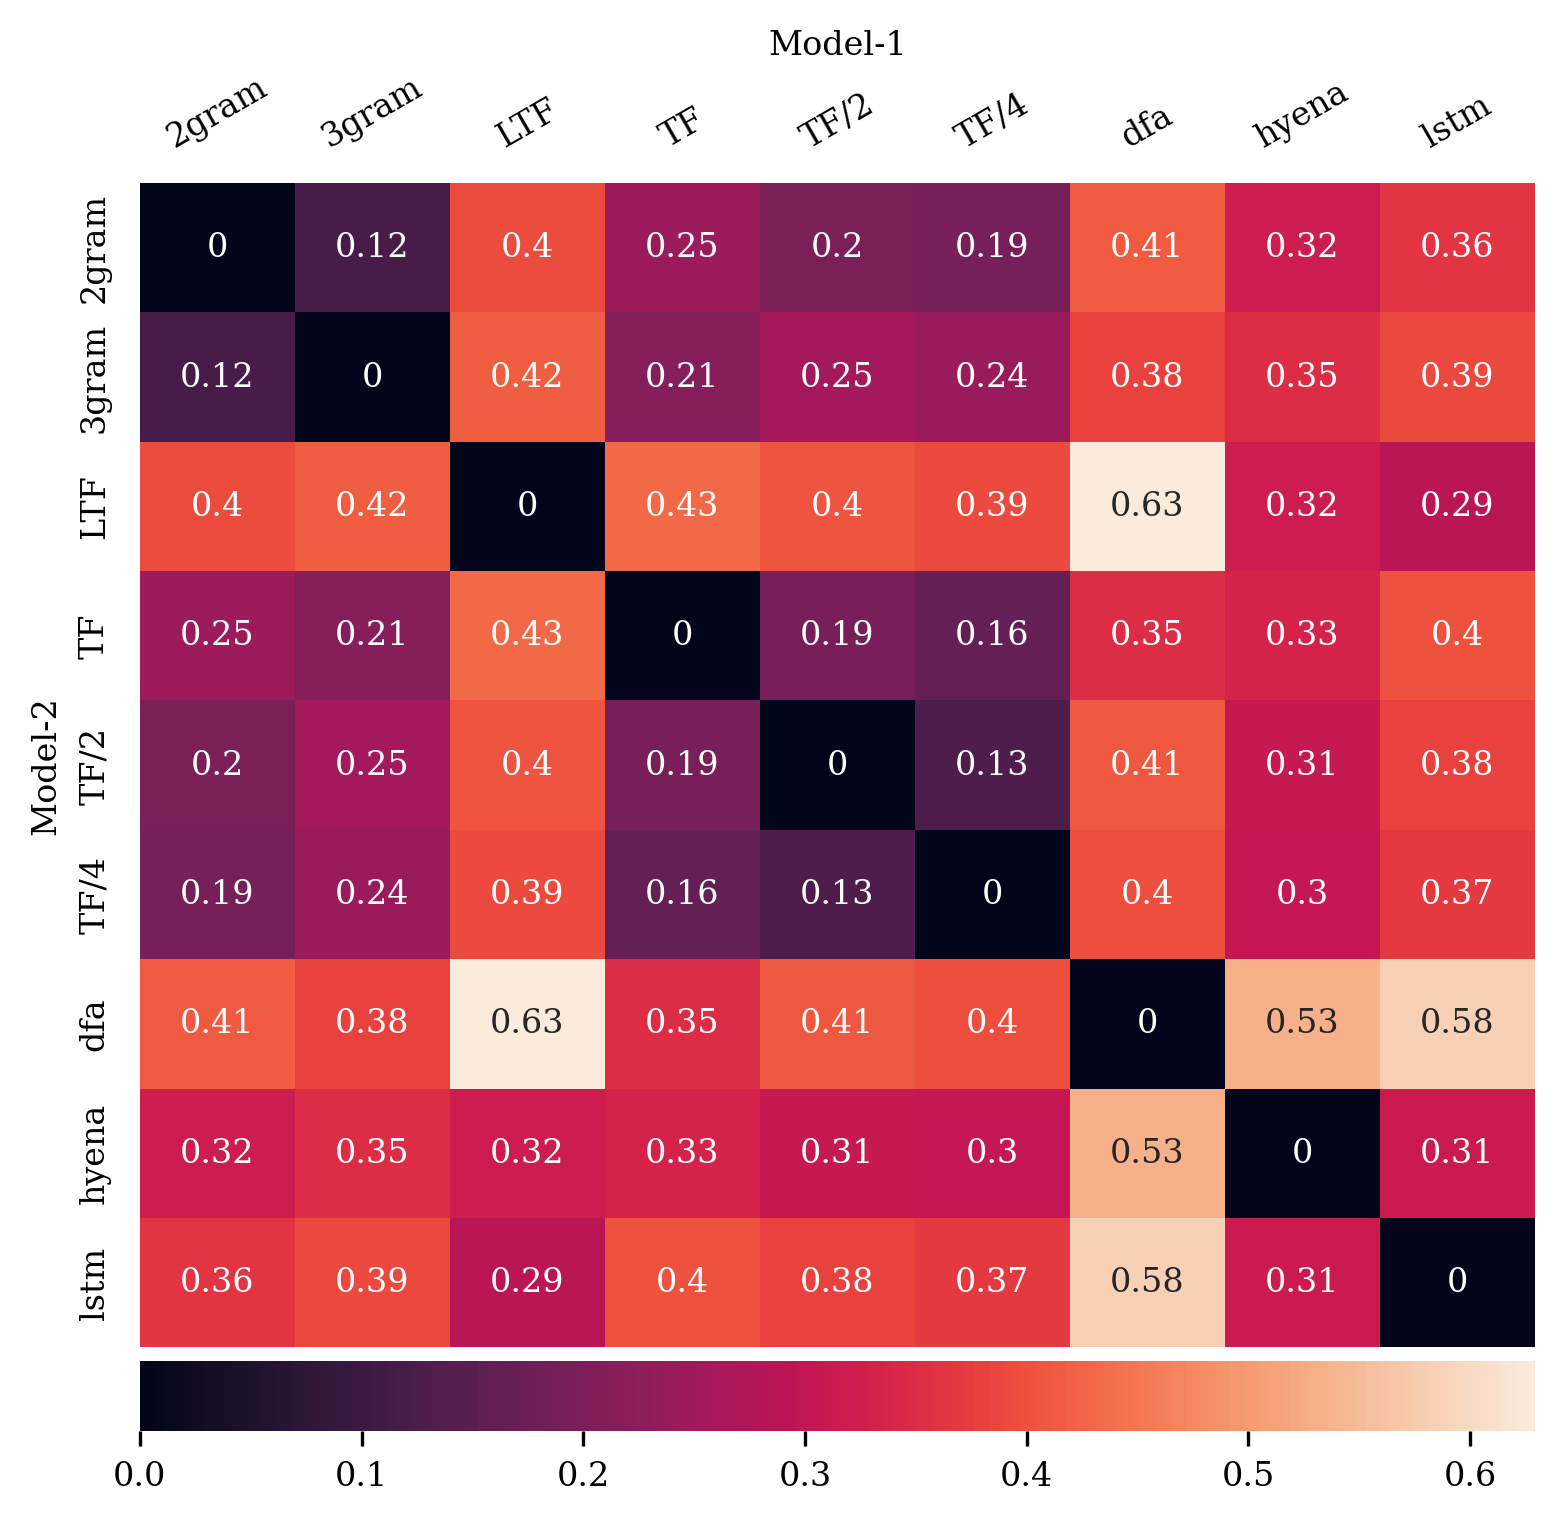

In [15]:
plot_l1_table(results, num_examples=2500, offset=0, max_len=100)

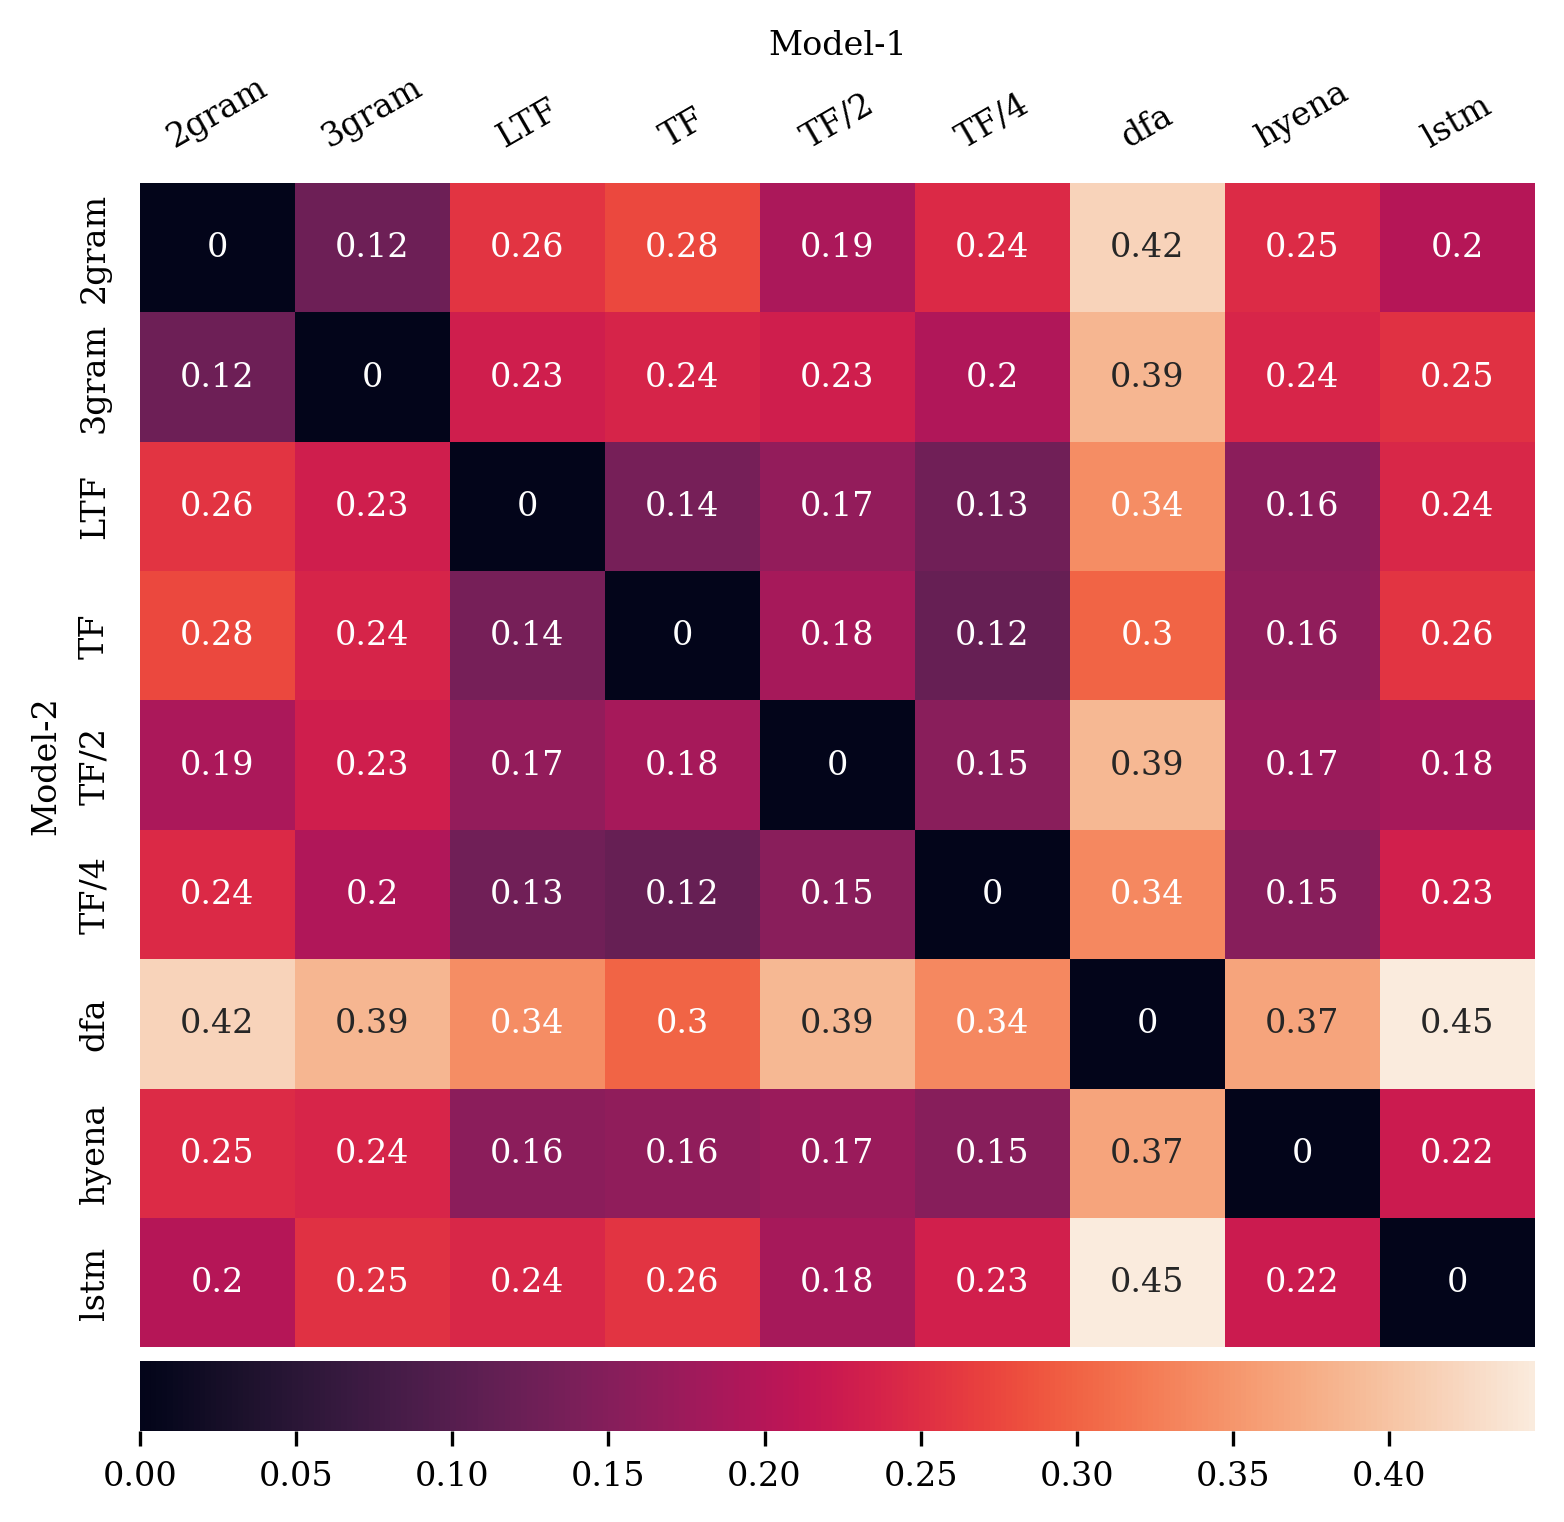

In [16]:
plot_l1_table(results, num_examples=40000, offset=0, max_len=100)

In [17]:
# hard_indices = {}
# for num_examples in (1000, 2500, 5000, 10000, 20000, 40000):
#     hard_indices[num_examples] = [
#         ind
#         for ind, r in enumerate(results[num_examples]["transformer"])
#         if len(r["dfa"].dfa._states) > 7 and len(r["dfa"].dfa.alphabet) > 10
#     ]

In [18]:
dfa_metrics = []
for metric in ("l1", "kl", "acc"):
    for num_examples in (1000, 2500, 5000, 10000, 20000, 40000):
        for model in results[num_examples].keys():
            if model != "dfa":
                if model not in ("3gram", "2gram"):
                    model_probs = get_model_probs(results[num_examples][model])
                elif model in ("3gram", "2gram"):
                    model_probs = get_model_probs(results[num_examples][model], softmax=False)
                else:
                    model_probs = results[num_examples][model]
                dfa_probs = results[num_examples]["dfa"]
                # # hard
                # model_probs = [model_probs[i] for i in hard_indices[num_examples]]
                # dfa_probs = [dfa_probs[i] for i in hard_indices[num_examples]]
                try:
                    if metric == "l1":
                        value = get_l1_loss(model_probs, dfa_probs, dfa_probs) / 2
                    elif metric == "kl":
                        value = get_kl(model_probs, dfa_probs)
                    elif metric == "acc":
                        value = get_greedy_dfa_accuracy(model_probs, dfa_probs)
                    dfa_metrics.append(
                        {
                            "model": model,
                            "metric": metric,
                            "value": value,
                            "num_examples": num_examples,
                        }
                    )
                except Exception as e:
                    print(e)
                    print(model, num_examples)

In [19]:
# deep json to dataframe
df = pd.DataFrame(dfa_metrics)

In [20]:
# make neurips conference quality plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import scienceplots

plt.style.use(['science','ieee'])


plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['xtick.minor.visible'] = False
# dpi = 300
# plt.rcParams['figure.dpi'] = 300

In [21]:
color_palette = """1AA89E
302DBE
F17011
D3226F
6A6AF8
1461F0
5E00C9
E2BC09
BD4805
107F4B
B0E926""".split(
    "\n"
)
# convert to rgb
color_palette = [matplotlib.colors.to_rgb("#"+c) for c in color_palette]

In [22]:
metric_names = {
    "kl": "KL",
    "l1": "TVD",
    "acc": "Accuracy",
}

model_names = {
    "transformer": "Transformer",
    "transformer_2": "Transformer (2 layers)",
    "transformer_1": "Transformer (1 layers)",
    "lstm": "LSTM",
    "hyena": "Hyena",
    "h3": "H3",
    "s4d": "S4D",
    "linear_transformer": "Linear Transformer",
    "rwkv": "RWKV",
    "retention": "RetNet",
    "mamba": "Mamba",
}

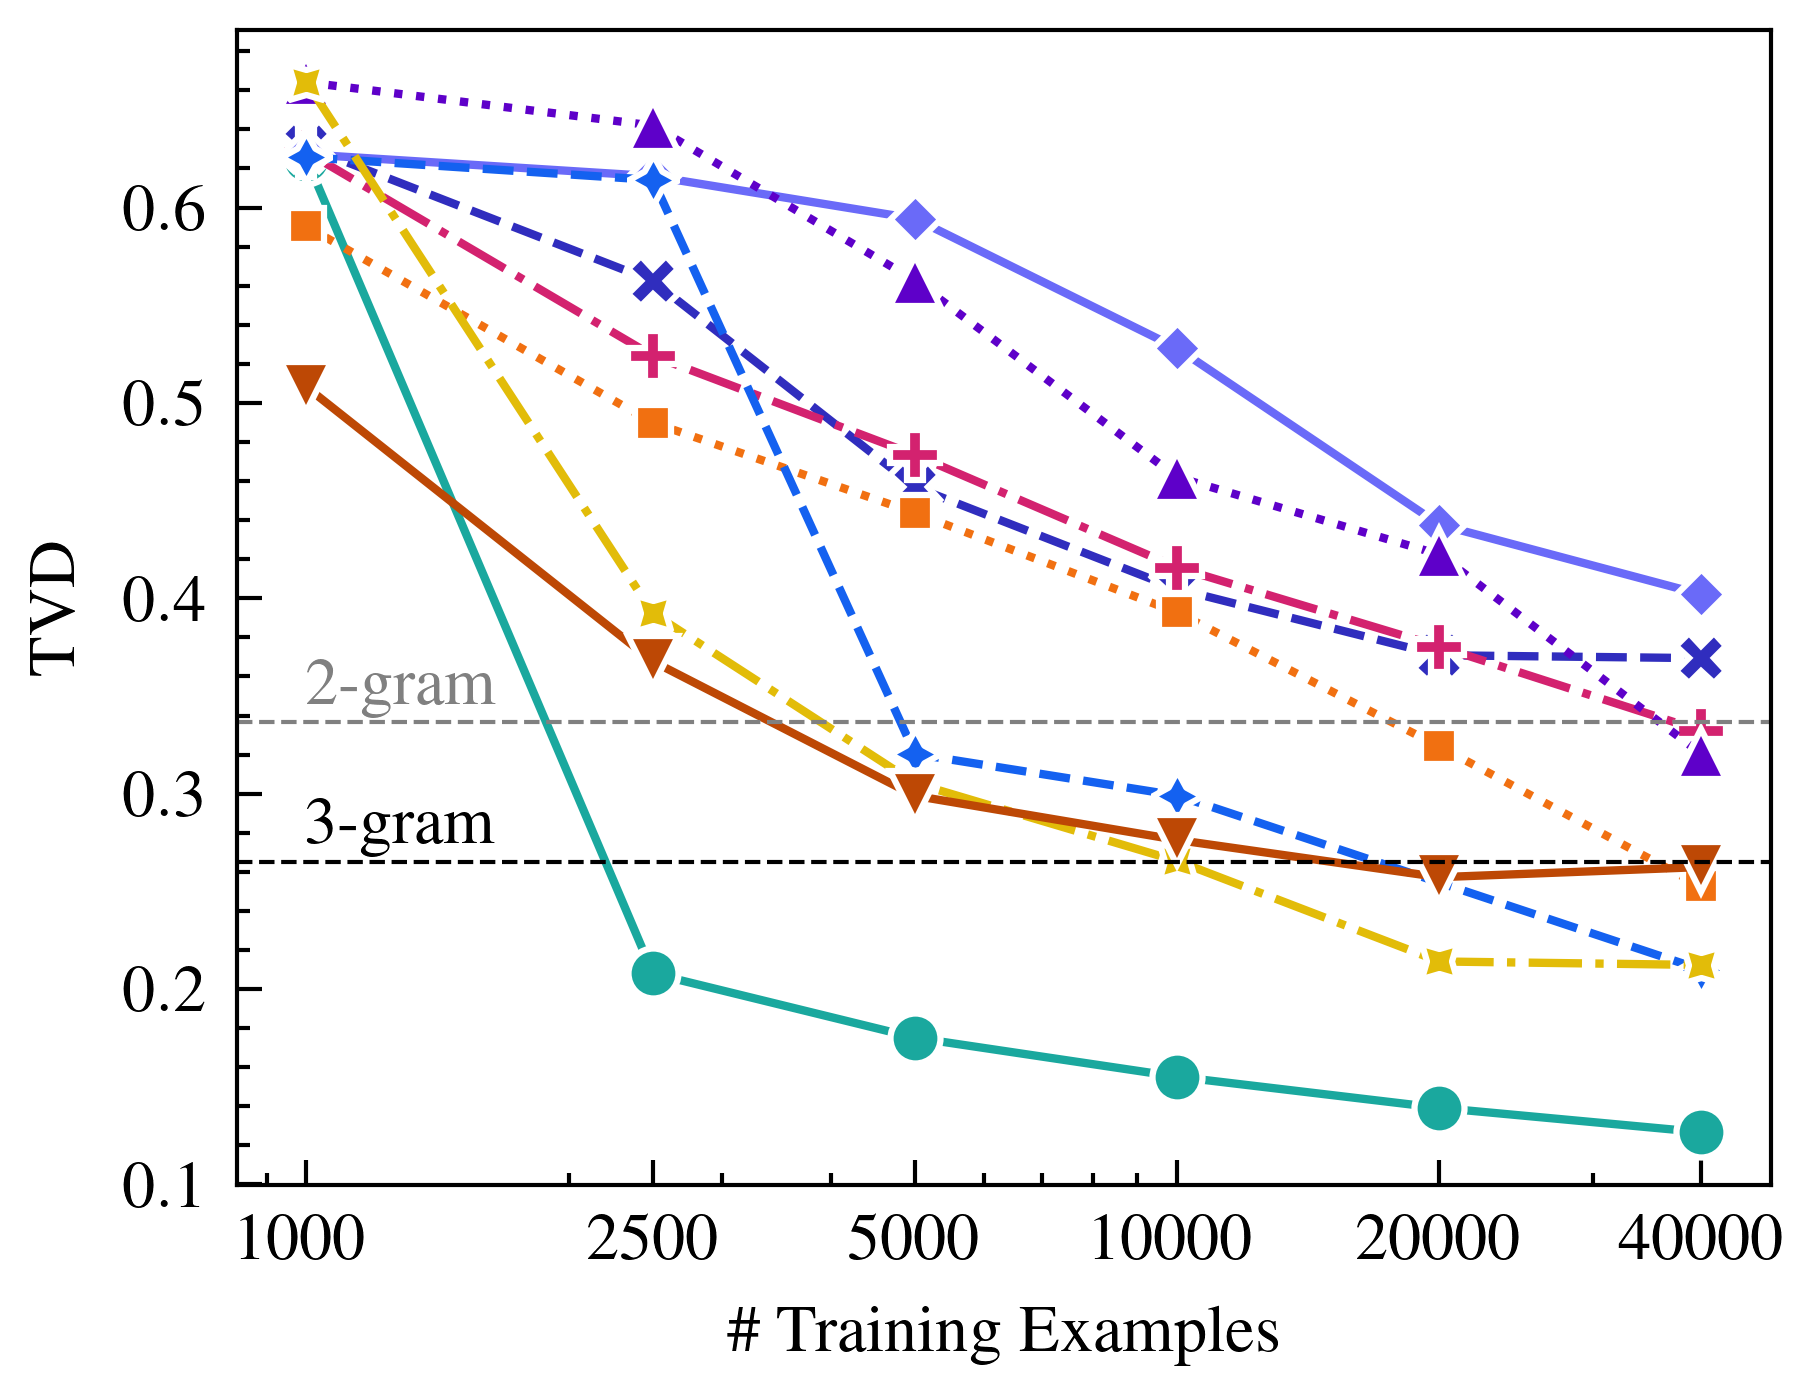

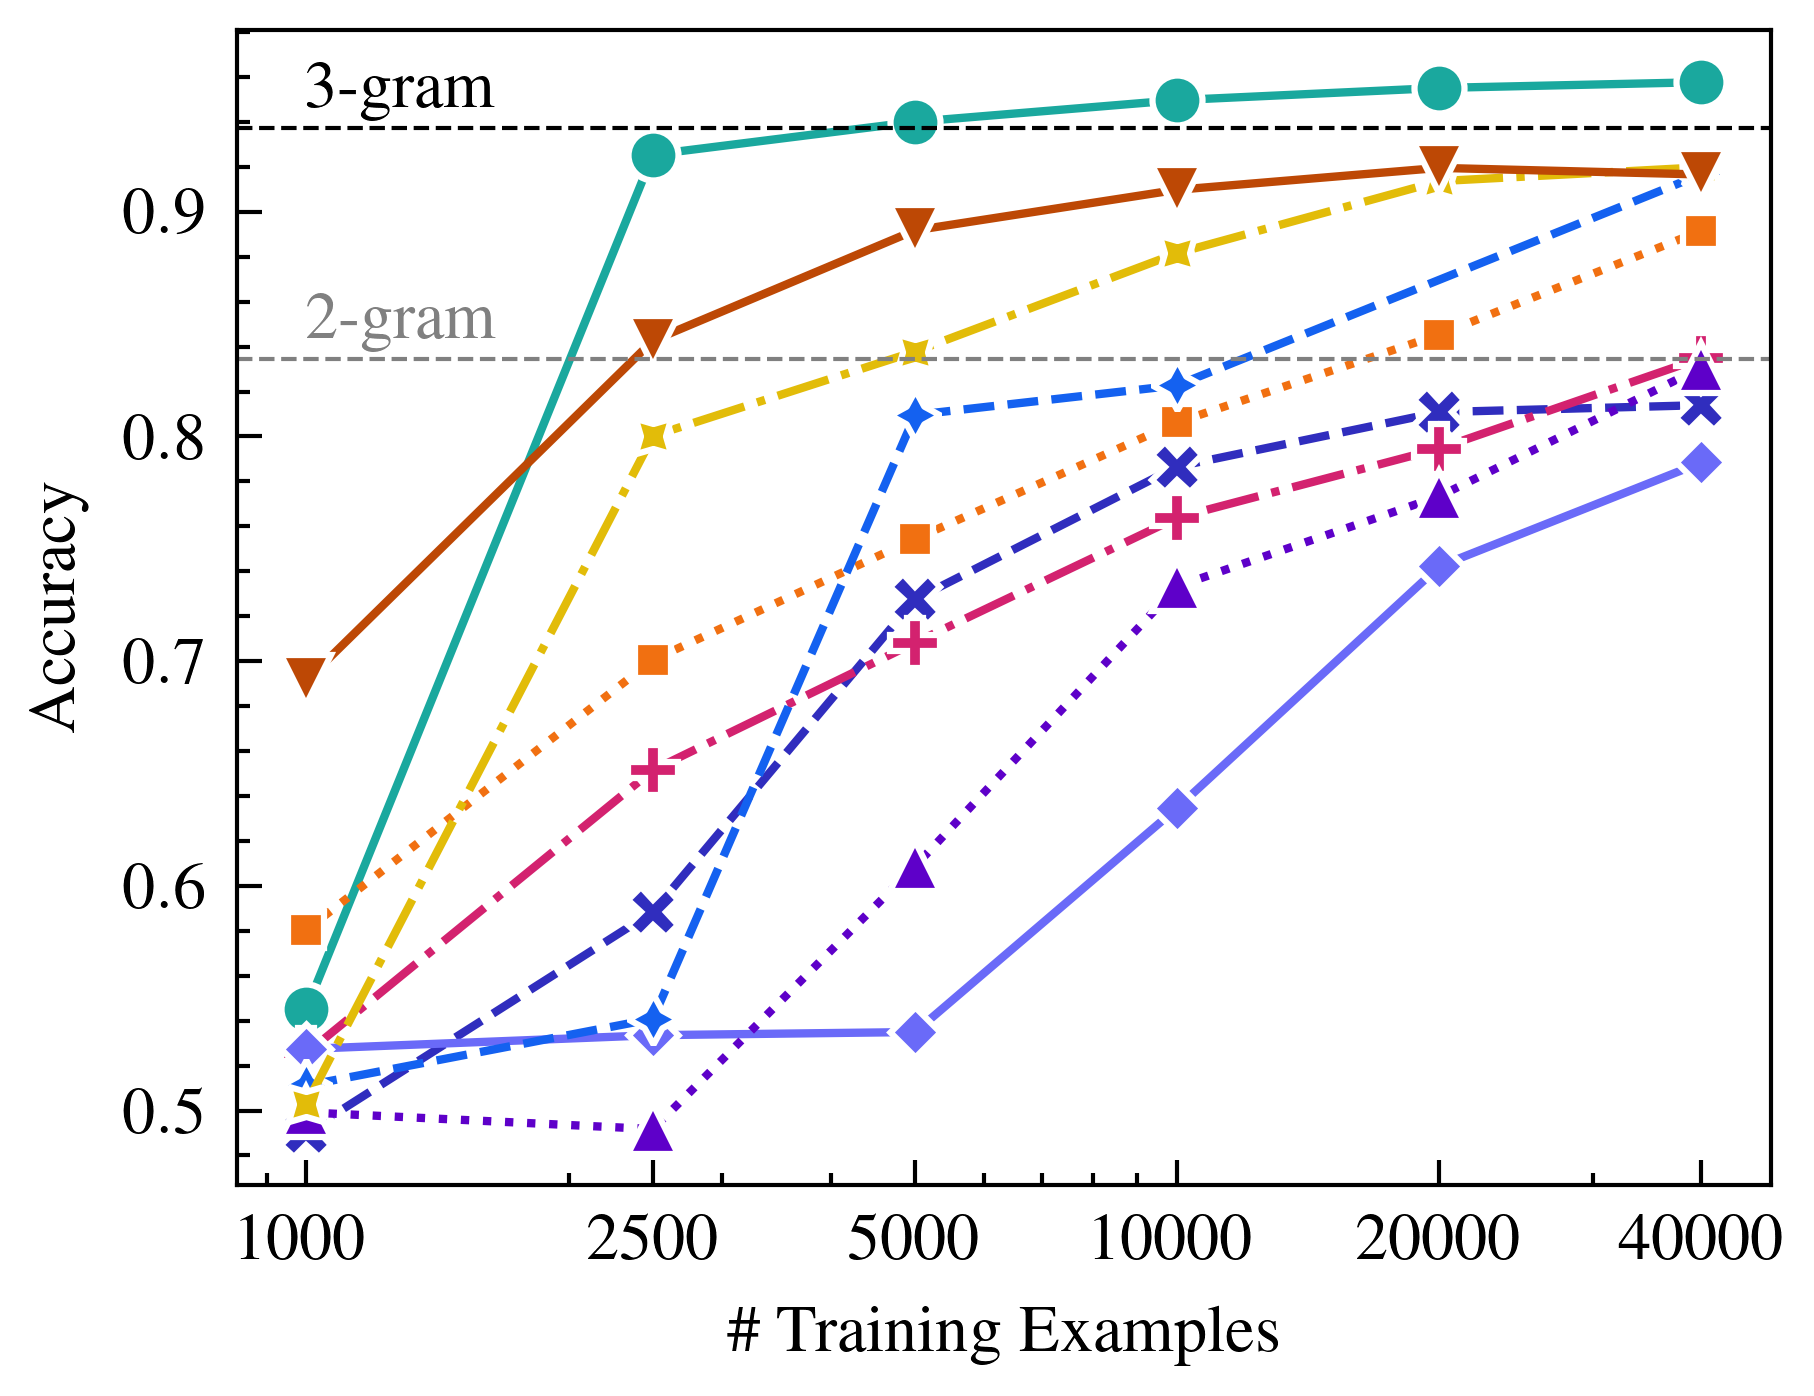

In [23]:
# fig size
for metric in ("l1", "acc"):
    data = df[
        (df.metric == metric)
        & ~(
            df.model.isin(
                [
                    "transformer_8",
                    "transformer_4",
                    "transformer_2",
                    "transformer_1",
                    "3gram",
                    "2gram",
                ]
            )
        )
    ]
    data = data.replace({"model": model_names})
    # new figure
    fig, ax = plt.subplots()
    ax = sns.lineplot(
        data=data,
        x="num_examples",
        y="value",
        hue="model",
        style="model",
        markers=True,
        dashes=False,
        palette=color_palette,
        legend="full",
    )

    ax.legend().set_visible(False)
    ax.set_xlabel("\# Training Examples")
    ax.set_ylabel(metric_names[metric])
    ax.set(xscale="log")
    ax.set_xticks([1000, 2500, 5000, 10000, 20000, 40000])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # remove minor
    ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

    # show 2gram and 3gram as horizontal line with texts on them
    ax.axhline(
        y=df[(df.metric == metric) & (df.model == "3gram")].value.max(),
        color="black",
        linestyle="--",
        linewidth=0.5,
    )
    ax.text(
        1000,
        df[(df.metric == metric) & (df.model == "3gram")].value.max() + 0.01,
        "3-gram",
        color="black",
#         fontsize=12,
    )
    ax.axhline(
        y=df[(df.metric == metric) & (df.model == "2gram")].value.max(),
        color="gray",
        linestyle="--",
        linewidth=0.5,
    )
    ax.text(
        1000,
        df[(df.metric == metric) & (df.model == "2gram")].value.max() + 0.01,
        "2-gram",
        color="gray",
#        fontsize=12,
    )

    # save to pdf
    fig.savefig(f"figures/dfa_{metric}.pdf", bbox_inches="tight")

In [26]:
import wandb
api = wandb.Api()
entity, project = "akyurek", "associative_recall_learning_curves_eval"
runs = api.runs(entity + "/" + project)

summary_list, config_list, name_list, attr_list = [], [], [], []
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items()})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

    #
    attr_list.append(run._attrs)


runs_df_ar = pd.DataFrame(
    {
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "attr": attr_list,
    }
)

In [32]:
def get_nested_arg(x, args):
    for arg in args:
        try:
            x = x[arg]
        except:
            return None
    return x

In [34]:
def get_ckpt(x):
    ckpt = x.config["train"]
    ckpt = ckpt["ckpt"]
    if ckpt is None:
        folder = name_to_folder.get(x.attr["name"], None)
        if folder:
            ckpt = os.path.join(
                "/raid/lingo/akyurek/git/iclmodels/",
                folder,
                # "checkpoints",
                # "val",
                # "loss.ckpt",
            )

    return ckpt

In [35]:
for metric in ["dfa_accuracy", "model_dfa_diff", "loss", "accuracy_ignore_index"]:
    runs_df_ar[f"final_test/{metric}"] = runs_df_ar.summary.map(
        lambda x: x.get(f"final_test/{metric}", None)
    )
for config in [
    "model.layer._name_",
    "dataset.num_examples",
    "model.n_layer",
    "model.d_model",
    "optimizer.lr",
    "optimizer.weight_decay",
    "experiment",
    "hydra.run.dir",
    "model.attn_cfg.n_heads",
    "model.attn_cfg.num_heads",
    "dataset.vocab_size",
    "dataset.input_seq_len",
    "dataset.batch_size",
    "model.attn_layer_idx",
]:
    config_parts = config.split(".")
    # get the value by nested index
    runs_df_ar[config] = runs_df_ar.config.map(lambda x: get_nested_arg(x, config_parts))

# if model.layer._name_ is None, set it to linear attention
runs_df_ar["model.layer._name_"] = runs_df_ar["model.layer._name_"].fillna("linear_transformer")

runs_df_ar["ckpt"] = runs_df_ar.apply(get_ckpt, axis=1)


# runs_df.dropna(subset=["final_test/model_dfa_diff"], inplace=True)
runs_df_ar.sort_values(by="final_test/loss", ascending=True, inplace=True)

# remove columns
runs_df_ar.drop(columns=["summary", "config", "attr"], inplace=True)

In [36]:
runs_df_ar

,name,final_test/dfa_accuracy,final_test/model_dfa_diff,final_test/loss,final_test/accuracy_ignore_index,model.layer._name_,dataset.num_examples,model.n_layer,model.d_model,optimizer.lr,optimizer.weight_decay,experiment,hydra.run.dir,model.attn_cfg.n_heads,model.attn_cfg.num_heads,dataset.vocab_size,dataset.input_seq_len,dataset.batch_size,model.attn_layer_idx,ckpt
191,valiant-shadow-95,None,None,0.002952,1.000,transformer,2500,8,128,0.00025,0.10,None,None,NaN,2.0,40,384,32,"{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': ...",None
285,usual-gorge-3,None,None,0.003626,1.000,transformer,5000,8,128,0.00010,0.10,None,None,NaN,1.0,40,384,32,"{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': ...",None
72,summer-water-214,None,None,0.003715,1.000,linear_transformer,2500,2,256,0.00025,0.10,None,None,NaN,2.0,40,384,32,"{'0': 0, '1': 1}",None
92,noble-cosmos-194,None,None,0.004328,1.000,transformer,1250,4,256,0.00025,0.01,None,None,NaN,1.0,40,384,32,"{'0': 0, '1': 1, '2': 2, '3': 3}",None
199,azure-microwave-87,None,None,0.004512,1.000,transformer,5000,8,128,0.00025,0.10,None,None,NaN,2.0,40,384,32,"{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': ...",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,hopeful-sun-265,None,None,5.098913,0.128,rwkv,625,2,256,0.00025,0.10,None,None,NaN,NaN,40,384,32,None,None
55,winter-voice-231,None,None,5.170772,0.284,h3,2500,2,256,0.00025,0.10,None,None,NaN,NaN,40,384,32,None,None
2,glowing-glitter-284,None,None,5.706687,0.128,rwkv,625,4,256,0.00010,0.10,None,None,NaN,NaN,40,384,32,None,None
61,divine-wildflower-225,None,None,5.935856,0.178,h3,2500,2,256,0.00010,0.10,None,None,NaN,NaN,40,384,32,None,None


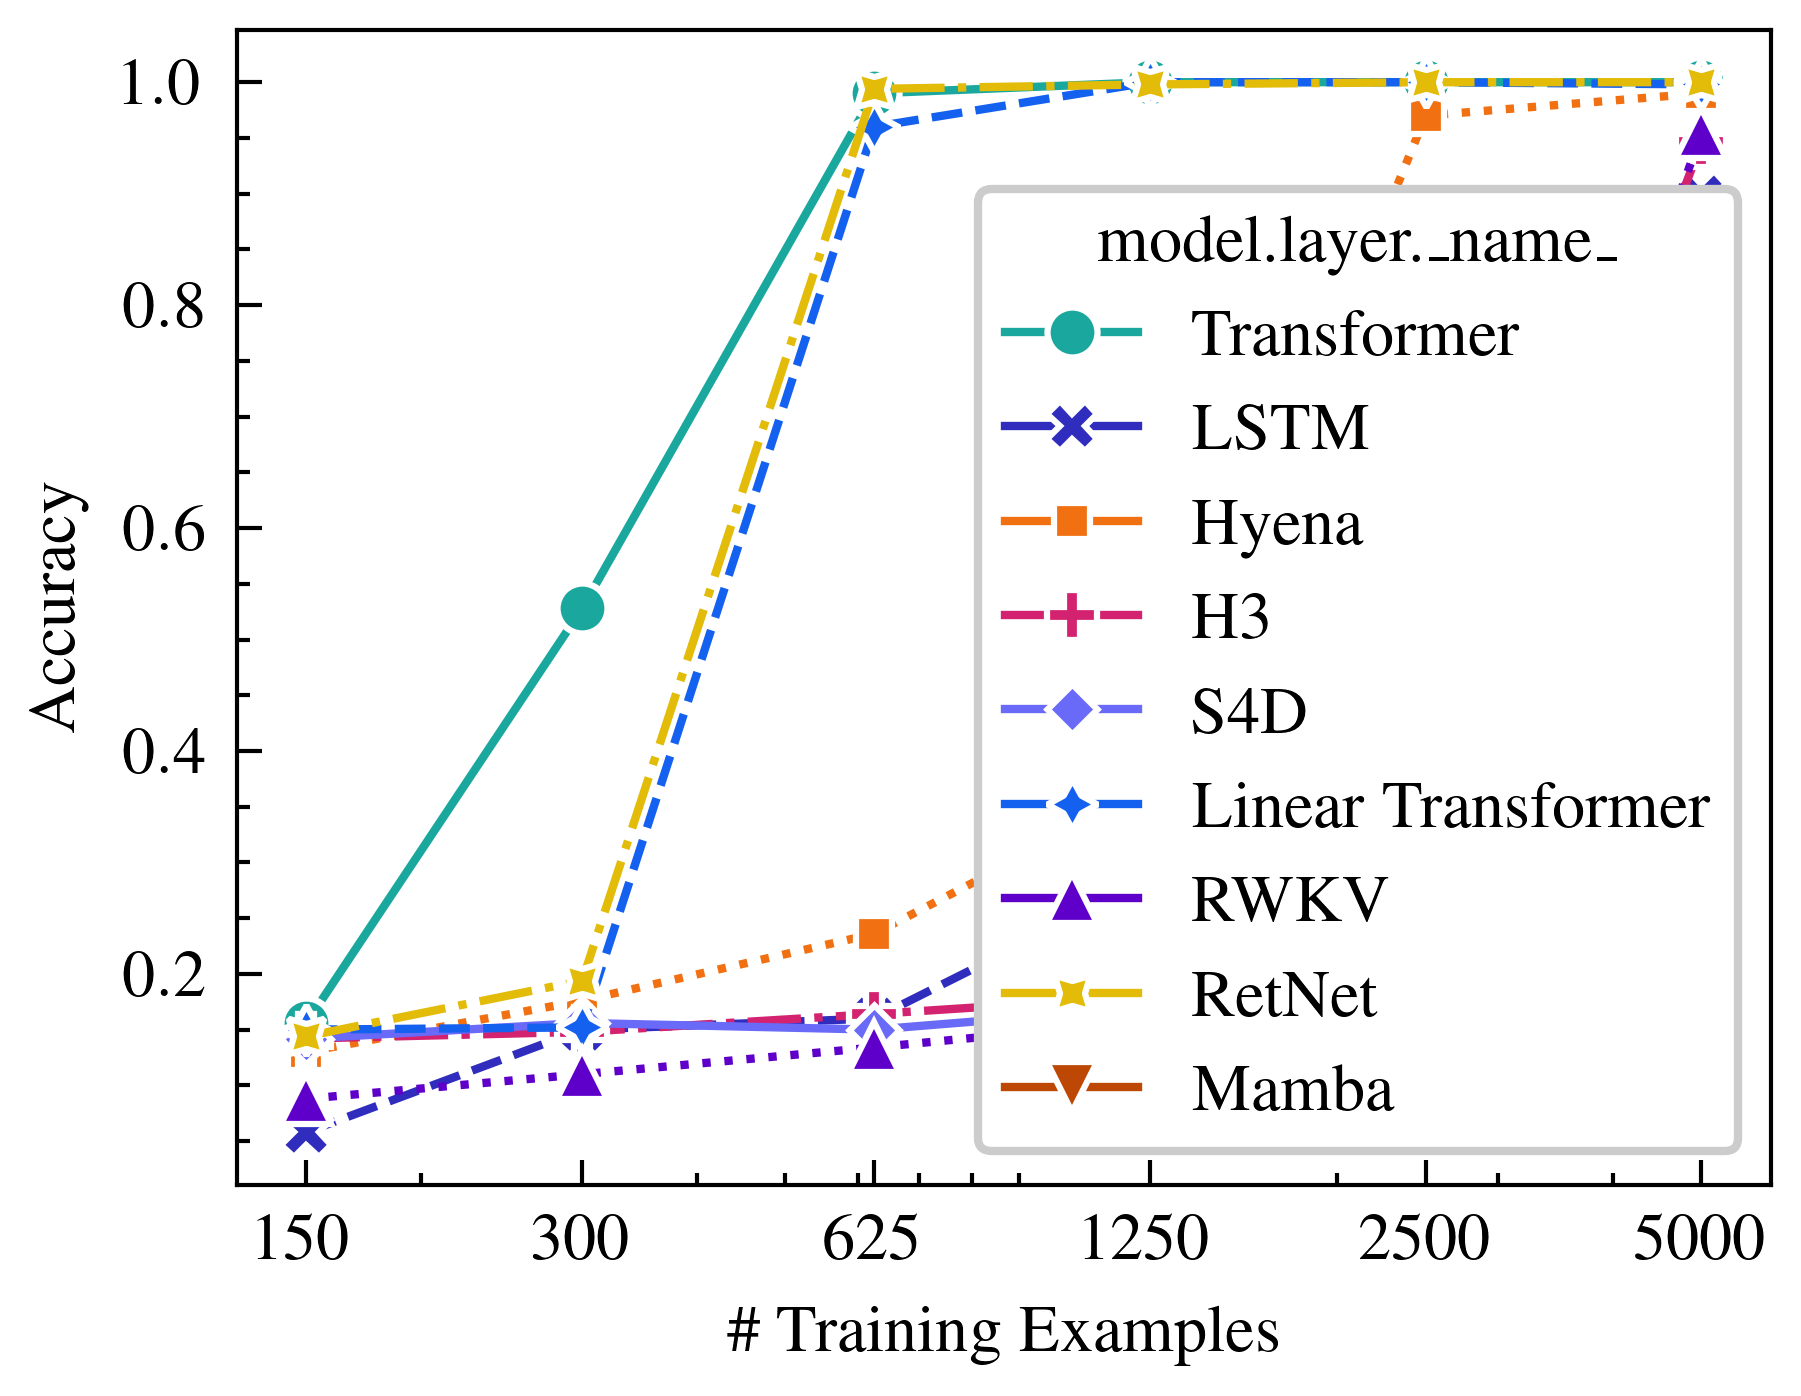

In [38]:
# fig size
# plt.rcParams.update({"figure.figsize": (6, 4)})
data = runs_df_ar.loc[
    runs_df_ar.groupby(["model.layer._name_", "dataset.num_examples"])[
        # "final_test/model_dfa_diff"
        "final_test/accuracy_ignore_index"
    ].idxmax()
]

data = data.replace({"model.layer._name_": model_names})
# display(data)
ax = sns.lineplot(
    data=data,
    x="dataset.num_examples",
    # y="final_test/model_dfa_diff",
    y="final_test/accuracy_ignore_index",
    hue="model.layer._name_",
    style="model.layer._name_",
    markers=True,
    dashes=False,
    palette=color_palette,
    hue_order=["Transformer", "LSTM", "Hyena", "H3", "S4D", "Linear Transformer", "RWKV", "RetNet", "Mamba"],
    style_order=["Transformer", "LSTM", "Hyena", "H3", "S4D", "Linear Transformer", "RWKV", "RetNet", "Mamba"],
)
# set legend false
# ax.legend().remove()
ax.set_xlabel("\# Training Examples")
ax.set_ylabel("Accuracy")
ax.set(xscale="log")
ax.set_xticks([150, 300, 625, 1250, 2500, 5000])
# ax.set_xticks([1000, 2500, 5000, 10000, 20000, 40000])
# ax.legend(title='Model')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# save figure as pdf
plt.savefig("figures/assoc_accuracy.pdf")